In [1]:
import findspark
import pandas as pd
findspark.init()
findspark.find()

'H:\\spark-3.3.1-bin-hadoop2'

In [2]:
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [3]:
#Using the codes above, we built a spark session and set a name for the application. Then, the data was cached in off-heap memory to avoid storing it directly on disk, and the amount of memory was manually specified.
spark = SparkSession.builder.appName('FlightPrices').config("spark.memory.offHeap.enabled","true").config("spark.memory.offHeap.size","10g").config("spark.authenticate.secret","test123").getOrCreate()

In [4]:
#an escape character to avoid commas in the .csv file when parsing
dataframe = spark.read.csv('./data.csv', header=True,escape="\"")

In [5]:
dataframe.show(n=5, truncate=False, vertical=True)

-RECORD 0-------------------------------------------------------------
 legId                             | 9ca0e81111c683bec1012473feefd28f 
 searchDate                        | 2022-04-16                       
 flightDate                        | 2022-04-17                       
 startingAirport                   | ATL                              
 destinationAirport                | BOS                              
 fareBasisCode                     | LA0NX0MC                         
 travelDuration                    | PT2H29M                          
 elapsedDays                       | 0                                
 isBasicEconomy                    | False                            
 isRefundable                      | False                            
 isNonStop                         | True                             
 baseFare                          | 217.67                           
 totalFare                         | 248.60                           
 seats

count number of rows

In [6]:
dataframe.count()

13900000

In [7]:
#show columns and their datatype
dataframe.printSchema()

root
 |-- legId: string (nullable = true)
 |-- searchDate: string (nullable = true)
 |-- flightDate: string (nullable = true)
 |-- startingAirport: string (nullable = true)
 |-- destinationAirport: string (nullable = true)
 |-- fareBasisCode: string (nullable = true)
 |-- travelDuration: string (nullable = true)
 |-- elapsedDays: string (nullable = true)
 |-- isBasicEconomy: string (nullable = true)
 |-- isRefundable: string (nullable = true)
 |-- isNonStop: string (nullable = true)
 |-- baseFare: string (nullable = true)
 |-- totalFare: string (nullable = true)
 |-- seatsRemaining: string (nullable = true)
 |-- totalTravelDistance: string (nullable = true)
 |-- segmentsDepartureTimeEpochSeconds: string (nullable = true)
 |-- segmentsDepartureTimeRaw: string (nullable = true)
 |-- segmentsArrivalTimeEpochSeconds: string (nullable = true)
 |-- segmentsArrivalTimeRaw: string (nullable = true)
 |-- segmentsArrivalAirportCode: string (nullable = true)
 |-- segmentsDepartureAirportCode: str

In [8]:
#drop duplicated/irrelevant columns
cols = ("segmentsCabinCode","segmentsDistance","segmentsDurationInSeconds","segmentsEquipmentDescription","segmentsAirlineCode","segmentsAirlineName","segmentsDepartureAirportCode","segmentsArrivalAirportCode","segmentsArrivalTimeRaw","segmentsArrivalTimeEpochSeconds","segmentsDepartureTimeRaw","segmentsDepartureTimeEpochSeconds")
df=dataframe.drop(*cols)

In [9]:
def findNullNoneEmpty(dataframe):
    df = dataframe.select([count(when(col(c).contains('None') | \
                            col(c).contains('NULL') | \
                            (col(c) == '' ) | \
                            col(c).isNull() | \
                            isnan(c), c 
                           )).alias(c)
                    for c in dataframe.columns])
    return df
null_df = findNullNoneEmpty(dataframe)
null_df = null_df.toPandas()


In [10]:
pd.set_option('display.max_columns', None)
null_df

,legId,searchDate,flightDate,startingAirport,destinationAirport,fareBasisCode,travelDuration,elapsedDays,isBasicEconomy,isRefundable,isNonStop,baseFare,totalFare,seatsRemaining,totalTravelDistance,segmentsDepartureTimeEpochSeconds,segmentsDepartureTimeRaw,segmentsArrivalTimeEpochSeconds,segmentsArrivalTimeRaw,segmentsArrivalAirportCode,segmentsDepartureAirportCode,segmentsAirlineName,segmentsAirlineCode,segmentsEquipmentDescription,segmentsDurationInSeconds,segmentsDistance,segmentsCabinCode
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1000181,0,0,0,0,0,0,0,0,270166,0,1000181,0


In [11]:
#deal with missing values
from pyspark.ml.feature import Imputer
df = df.withColumn('totalTravelDistance', df['totalTravelDistance'].cast('integer'))
imputer = Imputer(
inputCols=['totalTravelDistance'],
outputCols=['totalTravelDistance'])
df=imputer.fit(df).transform(df)

In [12]:
#drop all null rows
df = df.dropna()

In [13]:
#find any duplicated rows
df = df.distinct()

In [14]:
df.printSchema()

root
 |-- legId: string (nullable = true)
 |-- searchDate: string (nullable = true)
 |-- flightDate: string (nullable = true)
 |-- startingAirport: string (nullable = true)
 |-- destinationAirport: string (nullable = true)
 |-- fareBasisCode: string (nullable = true)
 |-- travelDuration: string (nullable = true)
 |-- elapsedDays: string (nullable = true)
 |-- isBasicEconomy: string (nullable = true)
 |-- isRefundable: string (nullable = true)
 |-- isNonStop: string (nullable = true)
 |-- baseFare: string (nullable = true)
 |-- totalFare: string (nullable = true)
 |-- seatsRemaining: string (nullable = true)
 |-- totalTravelDistance: integer (nullable = true)



In [25]:
#Summary Statistics
#df.describe(["totalTravelDistance","totalFare"]).show()

max_value = df.agg(max(df.totalFare)).collect()[0][0]

print(max_value)

999.93


In [17]:
import pandas

newdf = df.groupBy(floor(col("totalFare") / 100)).agg(avg(col("totalTravelDistance")))
newdf = newdf.sort("floor((totalFare / 100))", ascending=True)
newdf = newdf.toPandas()

pandas.set_option('display.max_rows', None)
newdf

,floor((totalFare / 100)),avg(totalTravelDistance)
0,0,734.015028
1,1,965.962077
2,2,1222.891998
3,3,1575.385799
4,4,1804.576334
5,5,2093.085390
6,6,2341.954166
7,7,2529.732548
8,8,2549.889266
9,9,2513.082260


<AxesSubplot:>

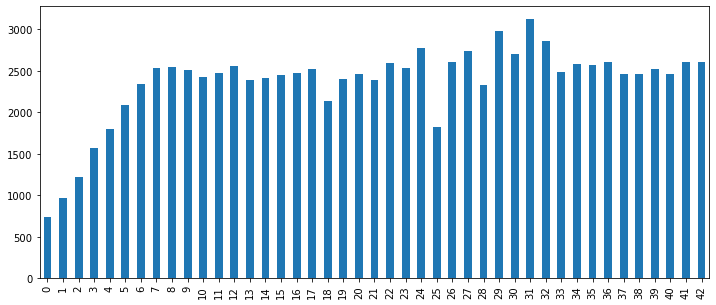

In [18]:
newdf["avg(totalTravelDistance)"].plot.bar(x = "floor((totalFare / 100))", y="avg(totalTravelDistance)", figsize=(12,5))